<a href="https://colab.research.google.com/github/daniel-hain/review-AI-industry_2023/blob/main/python/BERTopic_bibliomap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERTopic

* First tryout on topic modelling using BERT an reprentation learning.


## Setup

In [15]:
project_name = 'review-AI-industry_2023'

In [16]:
%load_ext autoreload
%autoreload 2

# Installing BERTopic
!pip install bertopic  -q gwpy

# When using openai (doesnt work right now)
!pip install --upgrade openai  -q gwpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Below when using CUDA UMAP
!pip install cudf-cu11 dask-cudf-cu11 --extra-index-url=https://pypi.nvidia.com -q gwpy
!pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com -q gwpy
!pip install cugraph-cu11 --extra-index-url=https://pypi.nvidia.com -q gwpy
!pip install --upgrade cupy-cuda11x -f https://pip.cupy.dev/aarch64 -q gwpy

In [74]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

import os
import pandas as pd
import numpy as np

In [19]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# Change directory

Mounted at /content/gdrive


In [20]:
# Set the environment variable for the OpenAI API Key
str = open('/content/gdrive/MyDrive/00_projects/apy_keys.txt', 'r').read()
os.environ["OPENAI_API_KEY"] = str # Alternative just type it. Make sure to not save a colab with your key

## Data

* Title + Abstracts of all articles

In [21]:
docs = pd.read_csv(f"https://github.com/daniel-hain/{project_name}/raw/main/data/data_text_all.csv")
docs.head()

,UT,PY,text,com,dgr_int
0,2-S2.0-85109857856,2021,innovation analytics and digital innovation ex...,1.0,1.165596
1,2-S2.0-85059300434,2019,a bibliometric analysis of research on big dat...,1.0,2.676760
2,2-S2.0-85061056232,2019,big data and dynamic capabilities: a bibliomet...,1.0,3.186791
3,2-S2.0-85109820553,2021,customers’ evaluation of mechanical artificial...,2.0,1.614281
4,2-S2.0-85118988974,2022,big data and analytics in hospitality and tour...,1.0,0.578224


# **Topic Modeling**



## Training



In [22]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import KeyBERTInspired
from bertopic.representation import TextGeneration

from sentence_transformers import SentenceTransformer
from transformers.pipelines import pipeline

from cuml.cluster import HDBSCAN # With GPU Axxeleration
from cuml.manifold import UMAP # With GPU Axxeleration
# from umap import UMAP # Without GPU Axxeleration
# from hdbscan import HDB # Without GPU Axxeleration

from sklearn.feature_extraction.text import CountVectorizer

In [23]:
# Own stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

new_stopwords = ["study", "studies", "paper", "insight", "insights", "research", "literature", "framework", "frameworks","rights","reserved" , "study", "studies", "these", "this", "paper", "result", "model", "approach", "article", "author", "method", "understand", "focus", "examine", "aim", "argue", "identify",
          "increase", "datum", "potential", "explore", "include", "issue", "propose", "address", "apply", "require", "analyse", "relate", "finding",
          "analyze", "discuss", "contribute", "publish", "involve", "draw", "lead", "exist", "set", "reduce", "create", "form", "explain", "play",
          "affect", "regard", "associate", "establish", "follow", "conclude", "define", "strong", "attempt", "finally", "elsevier", "offer",
          "taylor", "francis", "copyright", "springer", "wiley", "emerald", "copyright", "b.v"]
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
(docs.shape[0] / 15)

53.666666666666664

In [56]:
# Some hyperparameters
umap_n_neighbors = 10
umap_n_components = 10
umap_min_dist = 0

hdbscan_min_cluster_size = docs.shape[0] / 20
hdbscan_min_samples = hdbscan_min_cluster_size

stop_word_min_df = 2
stop_word_max_df = docs.shape[0]

# EMBEDDING MODEL:
embedding_model = "allenai-specter"

# DIMENSIONALITY REDUCTION
umap_model = UMAP(n_neighbors=umap_n_neighbors,
                  n_components=umap_n_components,
                  min_dist=umap_min_dist,
                  metric='cosine',
                  random_state=42)

# CLUSTERING: resuce min_cluster_size and min_samples
hdbscan_model = HDBSCAN(min_cluster_size=hdbscan_min_cluster_size,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True,
                        min_samples=hdbscan_min_samples)

# VECTORIZER: custom vectorizer to get rid of stopwords
vectorizer_model = CountVectorizer(stop_words=stpwrd,
                                   min_df = stop_word_min_df,
                                   max_df = stop_word_max_df)

# TFIDF Weighting: Weighting model with redued stoppwords
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,
                                     reduce_frequent_words=True)

In [57]:
from bertopic.representation import OpenAI

# Summarization with ChatGPT
summarization_prompt = """
I have a topic that is described by the following keywords: [KEYWORDS]
In this topic, the following documents are a small but representative subset of all documents in the topic:
[DOCUMENTS]

Based on the information above, please give a description of this topic in the following format:
topic: <description>
"""
summarization_model = OpenAI(model="gpt-3.5-turbo", chat=True, prompt=summarization_prompt, nr_docs=5, exponential_backoff=True, diversity=0.1)

# Representation models
representation_models = {
    "KeyBERT + MMR": [KeyBERTInspired(), MaximalMarginalRelevance(diversity=0.3)],
    "OpenAI_Label": OpenAI(model="gpt-3.5-turbo", exponential_backoff=True, chat=True, diversity=0.1),
    #"OpenAI_Summary": [KeyBERTInspired(), summarization_model],
}

In [58]:
# BEWRTopic: specify all custom models and n_grams
topic_model = BERTopic(nr_topics="auto",
                       language="english",
                       calculate_probabilities=True,
                       verbose=True,
                       n_gram_range=(1, 3),
                       # seed_topic_list=seed_topic_list, #
                       embedding_model=embedding_model,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       vectorizer_model=vectorizer_model,
                       ctfidf_model=ctfidf_model,
                       representation_model=representation_models)

In [59]:
topics, probs = topic_model.fit_transform(docs.loc[:,'text'])

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

2023-09-12 12:38:18,210 - BERTopic - Transformed documents to Embeddings
2023-09-12 12:38:18,275 - BERTopic - Reduced dimensionality
2023-09-12 12:38:18,311 - BERTopic - Clustered reduced embeddings
2023-09-12 12:38:36,562 - BERTopic - Reduced number of topics from 5 to 5


## Extracting Topics
* After fitting our model, we can start by looking at the results.
* Typically, we look at the most frequent topics first as they best represent the collection of documents.
* -1 refers to all outliers and should typically be ignored.

In [63]:
freq = topic_model.get_topic_info(); freq.head(50)

,Topic,Count,Name,Representation,KeyBERT + MMR,OpenAI_Label,Representative_Docs
0,-1,269,-1_ai_technology_service_use,"[ai, technology, service, use, customer, desig...","[adoption, business, consumers, consumer, serv...",[Factors influencing adoption of payments bank...,[e-health and wellbeing monitoring using smart...
1,0,272,0_innovation_data_big_digital,"[innovation, data, big, digital, capabilities,...","[innovation, business, firms, firm, strategic,...",[Innovation and Digital Transformation in Firms],[adoption of big data technology for innovatio...
2,1,155,1_ai_artificial_intelligence_human,"[ai, artificial, intelligence, human, automati...","[workplace, employees, employee, adoption, bus...",[Influence of Artificial Intelligence on Firm ...,[impact of artificial intelligence on employee...
3,2,56,2_industry_iot_technologies_manufacturing,"[industry, iot, technologies, manufacturing, i...","[industry, business, adoption, technologies, t...",[Industry 4.0 and the Impact of IoT Technologi...,"[technologies, opportunities and challenges of..."
4,3,53,3_robots_service_robot_hospitality,"[robots, service, robot, hospitality, hotel, h...","[adoption, consumer, consumers, customer, enco...",[Robots in Hospitality and Tourism Service],[spicing up hospitality service encounters: th...


## Attributes

* There are a number of attributes that you can access after having trained your BERTopic model:


| Attribute | Description |
|------------------------|---------------------------------------------------------------------------------------------|
| topics_               | The topics that are generated for each document after training or updating the topic model. |
| probabilities_ | The probabilities that are generated for each document if HDBSCAN is used. |
| topic_sizes_           | The size of each topic                                                                      |
| topic_mapper_          | A class for tracking topics and their mappings anytime they are merged/reduced.             |
| topic_representations_ | The top *n* terms per topic and their respective c-TF-IDF values.                             |
| c_tf_idf_              | The topic-term matrix as calculated through c-TF-IDF.                                       |
| topic_labels_          | The default labels for each topic.                                                          |
| custom_labels_         | Custom labels for each topic as generated through `.set_topic_labels`.                                                               |
| topic_embeddings_      | The embeddings for each topic if `embedding_model` was used.                                                              |
| representative_docs_   | The representative documents for each topic if HDBSCAN is used.                                                |

For example, to access the predicted topics for the first 10 documents, we simply run the following:

# **Visualization**
* There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time.
* Topic modeling is, to a certain extent, quite subjective. * Visualizations help understand the topics that were created.

## General topic relation

In [64]:
topic_model.visualize_topics()

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [65]:
topic_model.visualize_barchart(top_n_topics=50, n_words = 10)

In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

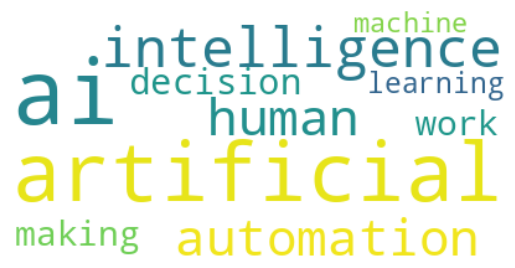

In [67]:
# Show wordcloud
create_wordcloud(topic_model, topic=1)

In [71]:
# Representative docs
rep_doc = topic_model.get_representative_docs()
rep_doc = pd.DataFrame(rep_doc)
rep_doc.T

,0,1,2
-1,e-health and wellbeing monitoring using smart ...,unreal influence: leveraging ai in influencer ...,factors influencing adoption of payments banks...
0,adoption of big data technology for innovation...,the impact of big data analytics on firms’ hig...,digital transformation challenges: strategies ...
1,impact of artificial intelligence on employees...,influence of artificial intelligence (ai) on f...,on the current state of combining human and ar...
2,"technologies, opportunities and challenges of ...",birth of industry 5.0: making sense of big dat...,"supply chain 4.0: concepts, maturity and resea..."
3,spicing up hospitality service encounters: the...,service robots and covid-19: exploring percept...,frontline robots in tourism and hospitality: s...


In [69]:
df_embeddings = topic_model.embedding_model.embed_documents(docs.loc[:,'text'])

In [70]:
topic_model.visualize_documents(docs.loc[:,'text'], embeddings=df_embeddings)

## Visualize Topic Hierarchy

* The topics that were created can be hierarchically reduced.
* In order to understand the potential hierarchical structure of the topics, we can create clusters and visualize how they relate to one another.
* This might also help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [ ]:
# Calculate Hirarchy
hierarchical_topics = topic_model.hierarchical_topics(docs.loc[:,'text'])

In [86]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [88]:
# Run the visualization with the original embeddings
topic_model.visualize_hierarchical_documents(docs.loc[:,'text'], hierarchical_topics, embeddings=df_embeddings, level_scale = 'log')

## Topics over time

In [89]:
# Calculate topics over time
topics_over_time = topic_model.topics_over_time(docs.loc[:,'text'],
                                                docs.loc[:,'PY'])

26it [00:00, 59.33it/s]


In [90]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=50)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [92]:
topic_model.visualize_heatmap(n_clusters=2, width=1000, height=1000)

# Optimal: Finetune topics

Only do if you think something should be changes

In [ ]:
# VECTORIZER: custom vectorizer to get rid of stopwords
#vectorizer_model = CountVectorizer(stop_words=stpwrd, min_df = 10)

# TFIDF Weighting: Weighting model with redued stoppwords
#ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,reduce_frequent_words=True)

## REPRESENTATION MODEL:
# rep_mm = MaximalMarginalRelevance(diversity=0.8)
# rep_kb = KeyBERTInspired()
# rep_oai = OpenAI()
# representation_model = rep_mm # [rep_mm, rep_kb]

# topic_model.update_topics(docs.loc[:,'text'], n_gram_range=(1, 3),
#                          vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_model)

In [ ]:
# Reduce topics if wanted
# topic_model.reduce_topics(docs, nr_topics=30)

## Visualize Topic Probabilities

- The variable `probabilities` that is returned from `transform()` or `fit_transform()` can  be used to understand how confident BERTopic is that certain topics can be found in a document.



In [93]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs.loc[:,'text'], calculate_tokens=True)

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


In [94]:
# Select a document
doc_nr = 102
docs.loc[doc_nr]

UT                                        2-S2.0-85030318485
PY                                                      2017
text       increasing the effectiveness of procurement de...
com                                                      1.0
dgr_int                                             0.890363
Name: 102, dtype: object

In [95]:
# Get the probability distribution
topic_model.visualize_distribution(probs[doc_nr], min_probability=0.01)

In [96]:
# Visualize the token-level distributions
doc_topic_dist = topic_model.visualize_approximate_distribution(docs.loc[doc_nr,'text'], topic_token_distr[doc_nr])
doc_topic_dist

,increasing,the,effectiveness,of,procurement,decisions,the,value,of,big,data,in,the,procurement,process,big,data,are,commonly,discussed,topic,and,their,value,in,marketing,and,sales,has,been,thoroughly,investigated,although,some,authors,have,also,discussed,their,relevance,to,purchasing,and,supply,management,the,literature,on,this,topic,remains,scant,this,paper,aims,to,investigate,the,role,of,big,data,in,supporting,the,procurement,process,and,the,implementation,of,procurement,practices,the,main,benefits,of,such,procurement,practices,for,companies,are,highlighted,by,presenting,the,results,of,focus,group,of,procurement,professionals,and,experts,and,discussing,four,exploratory,case,studies,supported,by,secondary,data,analysis,the,paper,addresses,how,and,in,which,format,big,data,affects,different,activities,in,the,procurement,process,and,which,benefits,procurement,professionals,can,expect,from,adopting,big,data
0_innovation_data_big_digital,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.108,0.108,0.108,0.108,0.000,0.000,0.000,0.103,0.103,0.103,0.103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


# Work in progress: Manual ChatGTP topic summary:

In [ ]:
top_n = 1
n_doc = hdbscan_min_cluster_size

promt_intro = "I want you to act as a professor in social science. I want you to identify the reearch topic of following documents, which are titles plus abstacts of scientific journal article publications. They are representative articles for the topic to be identified. The journal is called  'Environmental Innovation and Societal Transitions'. The journal offers a platform for reporting studies of innovations and socio-economic transitions to enhance an environmentally sustainable economy and thus solve structural resource scarcity and environmental problems, notably related to fossil energy use and climate change. This involves attention for technological, organizational, economic, institutional and political innovations as well as economy-wide and sector changes, such as in the areas of energy, transport, agriculture and water management. The journal aims to tackle the most difficult questions, dealing with social, economic, behavioral-psychological and political barriers and opportunities as well as their complex interaction. The journal is multidisciplinary in spirit and methodologically open, and invites contributions from a broad range of disciplines within the social, environmental and innovation sciences. Specific research areas covered include: Theoretical analysis, formal modeling, empirical studies, policy discussion and a critical survey of relevant literature. Practical cases may address transitions in specific sectors, cities or regions. Articles on historical transitions not specifically related to environment and sustainability are welcome if they include a section with unique lessons for sustainability transitions. A non-exhaustive list of keywords and themes is as follows: behavior in line with bounded rationality, development theories, diffusion of innovations, environmental regulation, formal modeling, geography of innovations, historical transitions, increasing returns to scale and path dependence, innovation policy, institutional barriers, international cooperation and coordination, learning-by-doing, learning curves, lock-in, new governance, niche markets, optimal technological diversity, regime analysis, social and political power, strategic niche management, rebound effect, recombinant innovation, sector structure, social learning, transition experiments, technological regimes, transition pathways/mechanisms, vested interests, visions of the future."

promt_doc_intro = "Now I provide you the 10 articles. Every article starts with an '-', and ends with a linebreak:"
promt_doc = topic_model.get_document_info(docs.loc[:,'text']).sort_values(['Representative_document', 'Probability'],ascending=False).groupby('Topic').head(n_doc)
promt_doc['Document'] = '- ' + promt_doc['Document']
promt_doc = promt_doc.groupby('Topic', as_index=False).agg({'Document' : ' \n '.join}).query("Topic == @top_n").reset_index().loc[0,'Document']
promt_key_intro = "Now that your recieved the corresponding documents, I will also provide you some keywords describing the topic. They are sepperated with an ','"

promt_key = pd.DataFrame(topic_model.get_topic(top_n))
promt_key = [', '.join(promt_key.loc[:,0])]

promt_final = "Your task is to summarize the topic by a short label of 2-7 words, plus a short description of 3-5 sentences. It should consider the article content and the provided keywords, both against the background of the journal they are published in. It should be brief, focussed, clear, and avoid redundancies. This summary should highlight the commonality of the documents. It should indicate the main theoretical theme, research framework applied, context, potential contributions and implications. It should also indicate if the research in this topic is more quantitative or qualitative, on a macro or micro level, and aimed at theoretical, policy, or industry implications."

print(promt_intro, promt_doc_intro, promt_doc, promt_key_intro, promt_key, promt_final, sep = " \n \n ")

# Export all topics

In [97]:
# save embeddings
pd.DataFrame(df_embeddings).to_csv('embeddings_specter.csv')

In [98]:
# all topic / documents
df_probs=pd.DataFrame(probs)
df_probs.insert(0, "UT", docs.UT)
pd.DataFrame(df_probs).to_csv('documents_topic.csv')

In [99]:
df_topic = topic_model.get_topic_info()
pd.DataFrame(df_topic).to_csv('topic_rep.csv')

# LDAViz (Tyout)

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis

In [ ]:
# Prepare data for PyLDAVis
top_n = 10
R = 10

topic_term_dists = topic_model.c_tf_idf_.toarray()[:top_n+1, ]
new_probs = probs[:, :top_n]
outlier = np.array(1 - new_probs.sum(axis=1)).reshape(-1, 1)
doc_topic_dists = np.hstack((new_probs, outlier))
doc_lengths = [len(doc) for doc in docs]
vocab = [word for word in topic_model.vectorizer_model.vocabulary_.keys()]
term_frequency = [topic_model.vectorizer_model.vocabulary_[word] for word in vocab]

In [ ]:
data = {'topic_term_dists': topic_term_dists,
        'doc_topic_dists': doc_topic_dists,
        'doc_lengths': doc_lengths,
        'vocab': vocab,
        'term_frequency': term_frequency}

In [ ]:
# Visualize using pyLDAvis
vis_data= pyLDAvis.prepare(**data,R=R, n_jobs = 1, mds='mmds')
pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data,"pyldavis.html")

In [ ]:
topic_model.c_tf_idf_

# TODO

* Fix datavis & advanced tipc from: https://colab.research.google.com/drive/1W7aEdDPxC29jP99GGZphUlqjMFFVKtBC?usp=sharing#scrollTo=XupETxy89uqd
* Integrate github / gdrive loading automatization
* Move to local
* Split training and evaluating model